# Principal Component Analysis for Stock Analysis

In [2]:
#importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import bs4 as bs
import requests

In [3]:
# getting tickers
def save_sp500_tickers():

    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'html')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        if not '.' in ticker:
            tickers.append(ticker.replace('\n',''))
        
    return tickers

tickers = save_sp500_tickers()

In [30]:
plt.style.use('fivethirtyeight')

In [31]:
prices = yf.download(tickers, start='2020-01-01')['Adj Close']

[*********************100%***********************]  503 of 503 completed


In [32]:
returns = prices.apply(np.log).diff(1)

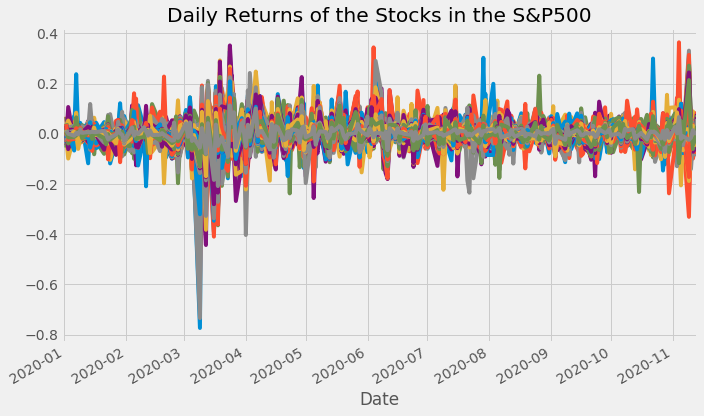

In [34]:
returns.plot(legend=0, figsize=(10,6), grid=True, title='Daily Returns of the Stocks in the S&P500')
plt.tight_layout()

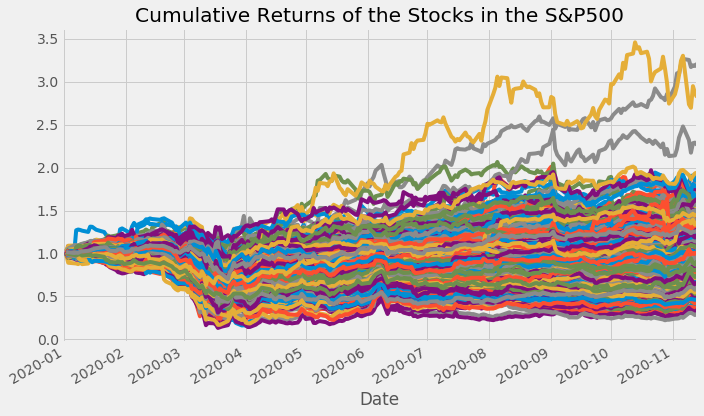

In [35]:
(returns.cumsum().apply(np.exp)).plot(legend=0, figsize=(10,6), grid=True, title='Cumulative Returns of the Stocks in the S&P500')
plt.tight_layout()


# Decomposing

In [36]:
from sklearn.decomposition import PCA

In [38]:
pca = PCA(1).fit(returns.fillna(0))

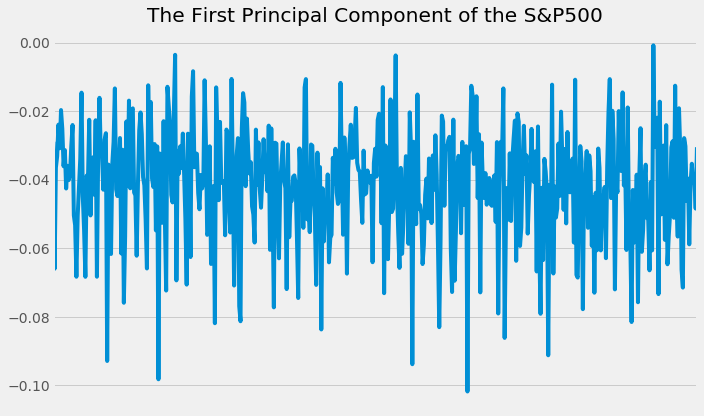

In [39]:
pc1 = pd.Series(index=returns.columns, data=pca.components_[0])

pc1.plot(figsize=(10,6), xticks=[], grid=True, title='The First Principal Component of the S&P500')
plt.tight_layout()

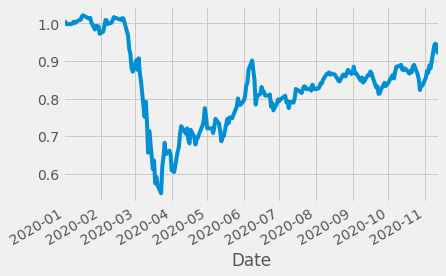

In [40]:
# Adding weights

weights = abs(pc1)/sum(abs(pc1))
simulated_returns = (weights*returns).sum(1)
simulated_returns.cumsum().apply(np.exp).plot()

# Downloading benchmark index

In [41]:
prices = yf.download(['SPY'], start='2020-01-01')['Adj Close']

[*********************100%***********************]  1 of 1 completed


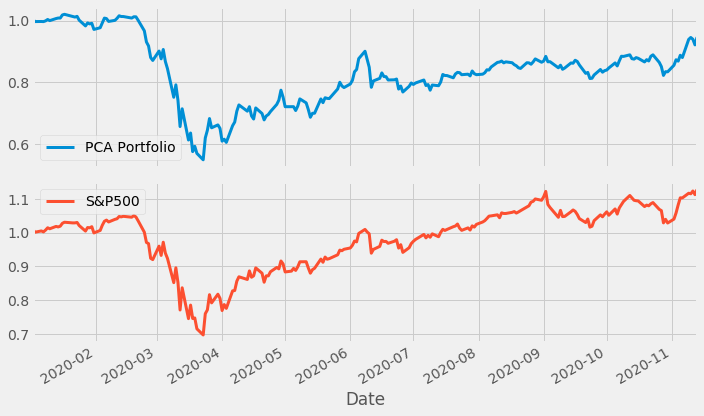

In [42]:
#Storing in Pandas Dataframe

returns_df = pd.concat([simulated_returns, prices.apply(np.log).diff(1)], 1)
returns_df.columns = ["PCA Portfolio", "S&P500"]

returns_df.dropna().cumsum().apply(np.exp).plot(subplots=True, figsize=(10,6), grid=True, linewidth=3);
plt.tight_layout()


# Analyzing the Weights

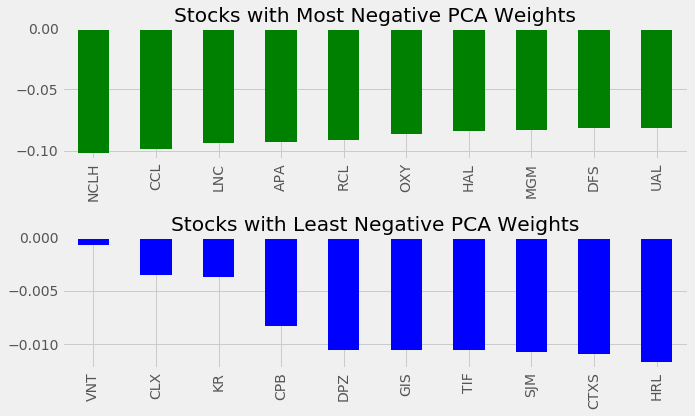

In [43]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
pc1.nsmallest(10).plot.bar(ax=ax[0], color='green', grid=True, title='Stocks with Most Negative PCA Weights')
pc1.nlargest(10).plot.bar(ax=ax[1], color='blue', grid=True, title='Stocks with Least Negative PCA Weights')

plt.tight_layout()

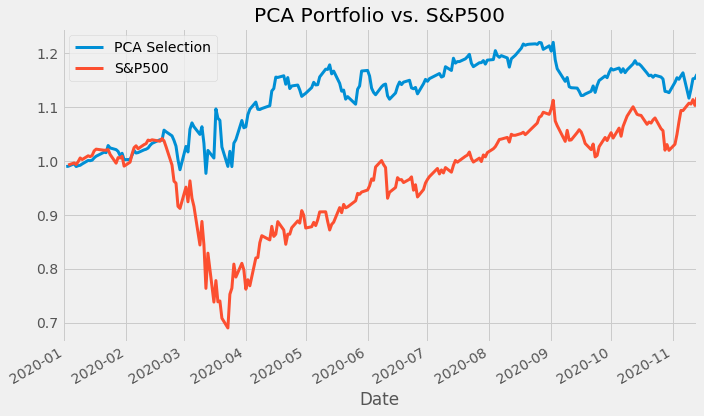

In [44]:
simulated_returns = returns[pc1.nlargest(10).index].mean(1)
simulated_returns.cumsum().apply(np.exp).plot(figsize=(15,5), grid=True, linewidth=3, title='PCA Portfolio vs. S&P500')
prices['2020':].apply(np.log).diff(1).cumsum().apply(np.exp).plot(figsize=(10,6), grid=True, linewidth=3)
plt.legend(['PCA Selection', 'S&P500'])

plt.tight_layout()